In [1]:
#!pip install lightgbm --quiet
!pip install xgboost --quiet

In [2]:
#import kagglehub

#path = kagglehub.dataset_download("claudiodavi/superhero-set")
#print("Path to dataset files:", path)

In [55]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from preprocessing import DataProcessor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, precision_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler, power_transform, MinMaxScaler
from sklearn.feature_selection import  SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
heroes_information = pd.read_csv("/root/.cache/kagglehub/datasets/claudiodavi/superhero-set/versions/1/heroes_information.csv", index_col=0)
heroes_information = heroes_information.drop_duplicates(subset='name')
super_hero_powers = pd.read_csv("/root/.cache/kagglehub/datasets/claudiodavi/superhero-set/versions/1/super_hero_powers.csv", index_col=0)
super_hero_powers.index.name = 'name'
super_hero_powers.reset_index(inplace=True)
df = heroes_information.merge(super_hero_powers, on='name', how='inner')

In [5]:
processor = DataProcessor(heroes_information)
processor.preprocessing()
processor.normalize_min_max()
cat_heroes_information = ['Gender', 'Eye color', 'Hair color', 'Publisher']
cat_super_hero_powers = list(super_hero_powers.columns)
cat_super_hero_powers.remove('name')
cat_cols = cat_super_hero_powers + cat_heroes_information
processor.onehot_encode_columns(cat_heroes_information)
model_base = processor.df
model_base.set_index('name', inplace=True)
model_base.head(3)

,Height,Alignment,Weight,Gender_Male,Gender_Unknown,Eye color_amber,Eye color_black,Eye color_blue,Eye color_blue / white,Eye color_brown,...,Hair color_Yellow,Hair color_black,Hair color_blond,Publisher_Dark Horse Comics,Publisher_George Lucas,Publisher_Marvel Comics,Publisher_Shueisha,Publisher_Star Trek,Publisher_Team Epic TV,Publisher_Unknown
name,,,,,,,,,,,,,,,,,,,,,
Abe Sapien,0.750000,good,0.237705,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Abin Sur,0.625000,good,0.442623,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Absorbing Man,0.791667,bad,0.704918,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
model_base.Alignment.value_counts()

,count
Alignment,
good,266
bad,99
neutral,10
Unknown,2


In [7]:
model_base = model_base[(model_base.Alignment == "good") | (model_base.Alignment == "bad") ]
model_base.Alignment.value_counts(normalize=True)

,proportion
Alignment,
good,0.728767
bad,0.271233


In [8]:
model_base.columns

Index(['Height', 'Alignment', 'Weight', 'Gender_Male', 'Gender_Unknown',
       'Eye color_amber', 'Eye color_black', 'Eye color_blue',
       'Eye color_blue / white', 'Eye color_brown', 'Eye color_gold',
       'Eye color_green', 'Eye color_green / blue', 'Eye color_grey',
       'Eye color_hazel', 'Eye color_indigo', 'Eye color_purple',
       'Eye color_red', 'Eye color_violet', 'Eye color_white',
       'Eye color_white / red', 'Eye color_yellow',
       'Eye color_yellow (without irises)', 'Eye color_yellow / blue',
       'Hair color_Black', 'Hair color_Black / Blue', 'Hair color_Blond',
       'Hair color_Brown', 'Hair color_Brown / White', 'Hair color_Green',
       'Hair color_Grey', 'Hair color_Indigo', 'Hair color_Magenta',
       'Hair color_No Hair', 'Hair color_Orange', 'Hair color_Orange / White',
       'Hair color_Pink', 'Hair color_Purple', 'Hair color_Red',
       'Hair color_Red / Grey', 'Hair color_Red / Orange',
       'Hair color_Red / White', 'Hair color_Silver

In [9]:
important_features = [
    "Weight",
    "Height",
    "Hair color_Black",
    "Hair color_Red",
    "Hair color_Blond",
    "Eye color_green",
    "Publisher_Marvel Comics",
    "Gender_Male",
    "Eye color_brown",
    "Hair color_No Hair",
    "Eye color_blue",
    "Hair color_Brown", "Alignment"
]
model_base = model_base[important_features]

In [10]:
model_base['Alignment'] = model_base['Alignment'].map({'good': 1, 'bad': 0})

X = model_base.drop(['Alignment'], axis = 1)

y = model_base['Alignment']

<ipython-input-10-ba6f8d775efc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_base['Alignment'] = model_base['Alignment'].map({'good': 1, 'bad': 0})


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 451, test_size= .25, stratify = y)

# Naive Bayes

In [12]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)

NB = cross_validate(estimator=GaussianNB(),
                    cv=skf,
                    scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc"],
                    return_estimator=True,
                    return_train_score=True,
                    verbose=2,
                    X=X_train,
                    y=y_train)

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


In [13]:
cv_df = pd.DataFrame(NB)
cv_df

,fit_time,score_time,estimator,test_accuracy,train_accuracy,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_roc_auc,train_roc_auc
0,0.004497,0.013759,GaussianNB(),0.600000,0.738532,0.495833,0.664747,0.495833,0.655527,0.495833,0.659552,0.518333,0.757435
1,0.004402,0.020626,GaussianNB(),0.672727,0.669725,0.613304,0.592157,0.629167,0.597697,0.616873,0.594293,0.706667,0.698699
2,0.005919,0.028997,GaussianNB(),0.600000,0.720183,0.549020,0.653608,0.558333,0.664268,0.545796,0.657929,0.686667,0.725083
3,0.011152,0.033187,GaussianNB(),0.629630,0.694064,0.584416,0.645318,0.600000,0.672934,0.583333,0.649617,0.703419,0.723994
4,0.010138,0.038533,GaussianNB(),0.648148,0.675799,0.568362,0.609916,0.576786,0.621069,0.570172,0.613372,0.708929,0.707652


In [14]:
teste = ['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro', 'test_roc_auc']
for icol in teste:
    print('%s -> mean: %1.2f +- %1.2f' %(icol, cv_df[icol].mean(), cv_df[icol].std()))

test_accuracy -> mean: 0.63 +- 0.03
test_precision_macro -> mean: 0.56 +- 0.04
test_recall_macro -> mean: 0.57 +- 0.05
test_f1_macro -> mean: 0.56 +- 0.05
test_roc_auc -> mean: 0.66 +- 0.08


Média de acurácia de treino dos modelos: 0.6996606761342214 
 Desvio padrão de acurácia de treino dos modelos: 0.02618790407502824
Média de acurácia de teste dos modelos: 0.6301010101010102 
 Desvio padrão de acurácia de teste dos modelos: 0.02812494008856409


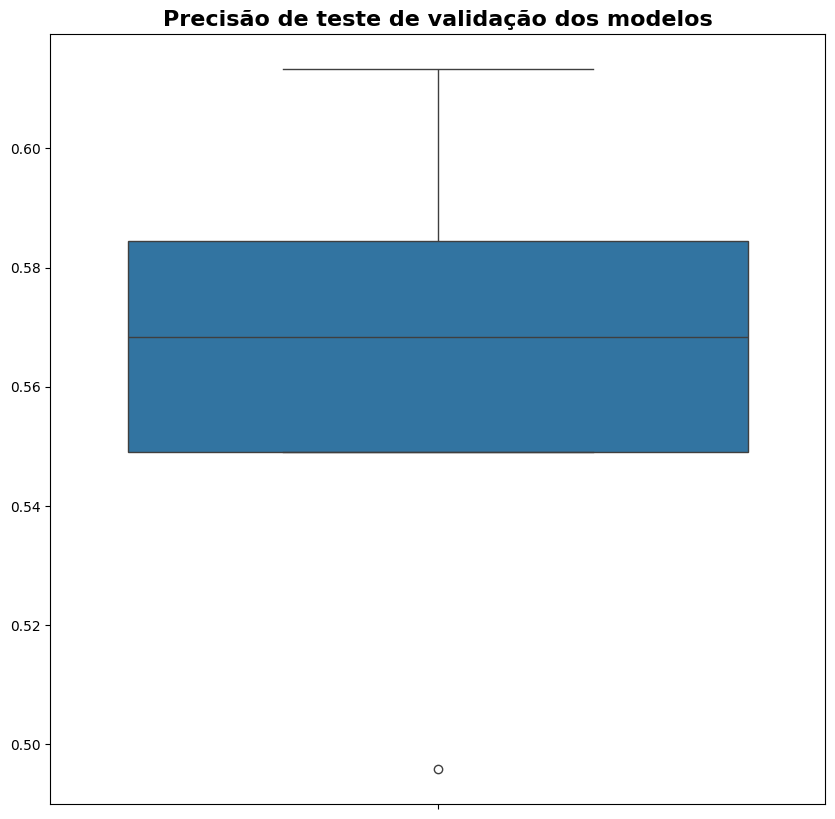

In [15]:
print("Média de acurácia de treino dos modelos:", NB["train_accuracy"].mean(), "\n", "Desvio padrão de acurácia de treino dos modelos:", NB["train_accuracy"].std())
print("Média de acurácia de teste dos modelos:", NB["test_accuracy"].mean(), "\n", "Desvio padrão de acurácia de teste dos modelos:", NB["test_accuracy"].std())

plt.figure(figsize = (10,10))
sns.boxplot(NB["test_precision_macro"])
plt.title("Precisão de teste de validação dos modelos", fontsize = 16, weight = "bold");


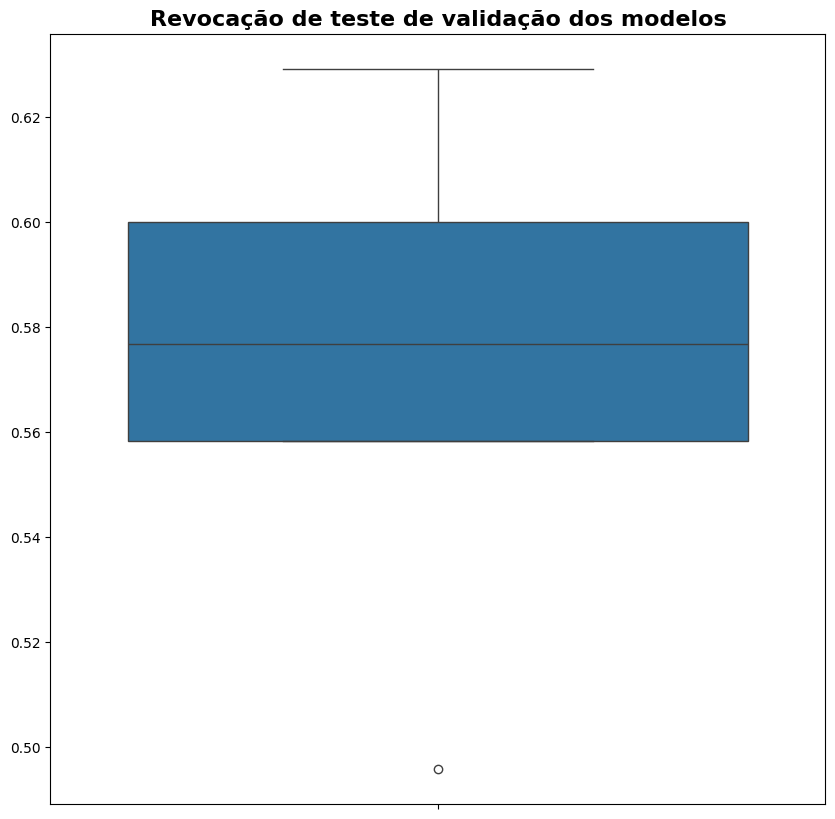

In [16]:
plt.figure(figsize = (10,10))
sns.boxplot(NB["test_recall_macro"])
plt.title("Revocação de teste de validação dos modelos", fontsize = 16, weight = "bold");

In [17]:
NB = NB["estimator"]

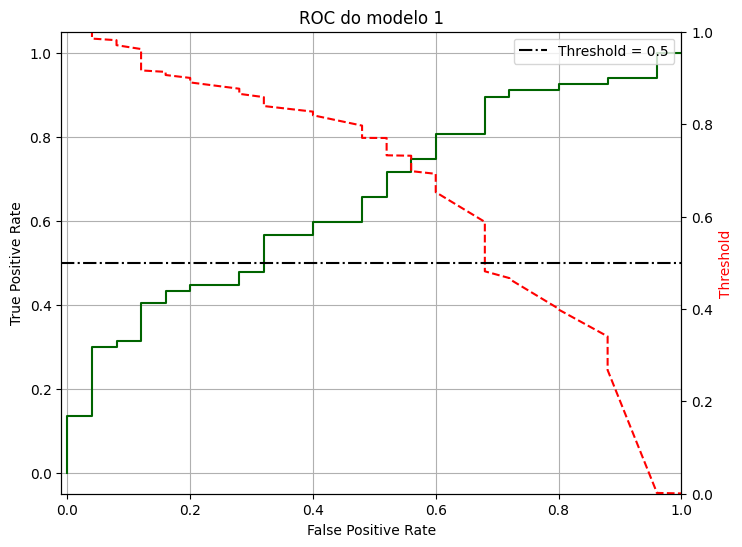

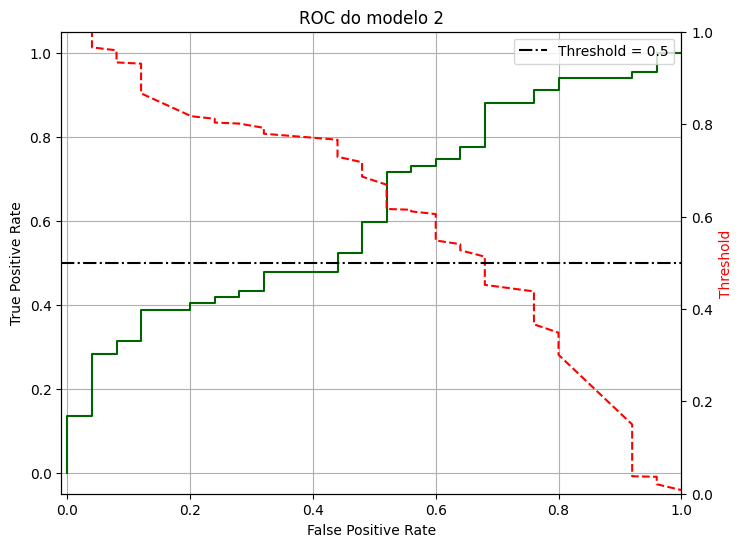

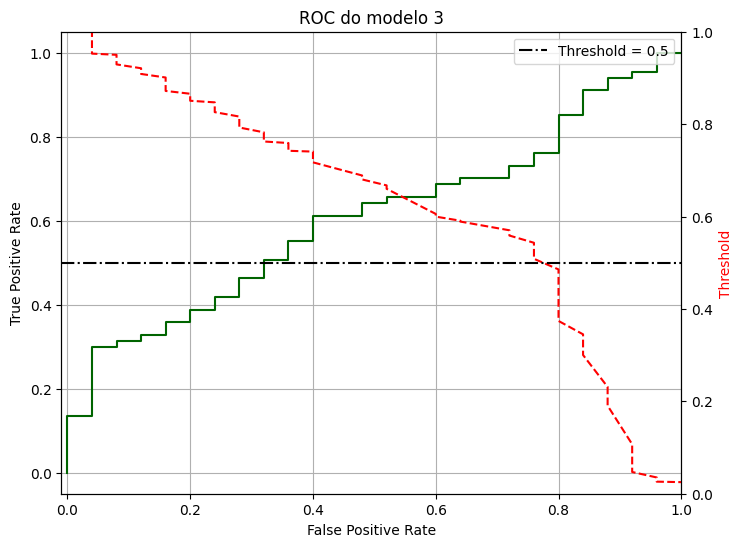

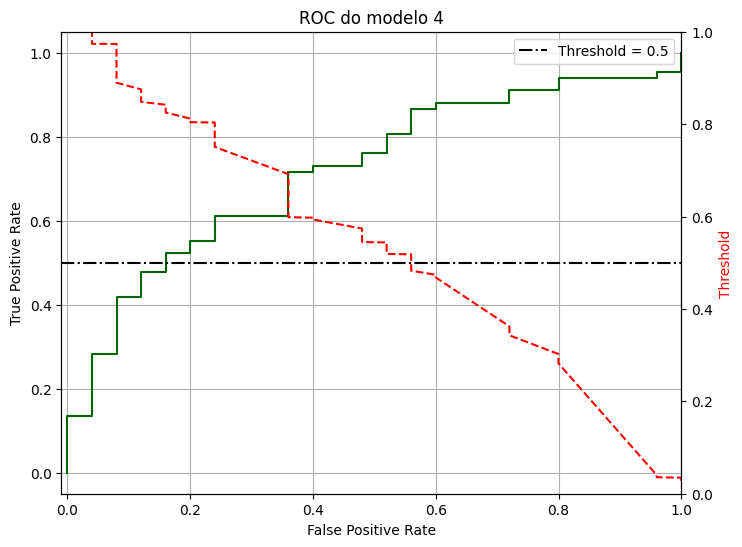

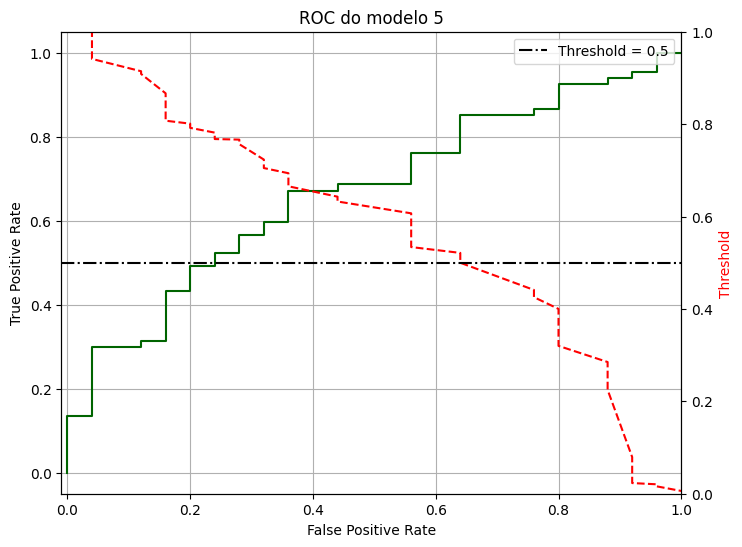

In [18]:
for i in range(5):
    y_pred_proba = NB[i].predict_proba(X_test)[::,1]
    fpr, tpr, sarrafo = roc_curve(y_test,  y_pred_proba)
    sarrafo = sarrafo[fpr <= 1]

    #create ROC curve
    plt.figure(figsize = (8,6))
    plt.plot(fpr,tpr, lw = 1.5, color = "darkgreen")
    plt.grid()
    plt.title(f"ROC do modelo {i + 1}")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, sarrafo, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([0,1])
    ax2.set_xlim([-0.01,1])
    ax2.axhline(y = 0.5, lw = 1.5, color = "black", ls = "-.", label = "Threshold = 0.5")
    plt.legend()

    plt.show()

In [19]:
for i in range(5):
    scores = [accuracy_score(y_test, NB[i].predict(X_test)),
                             balanced_accuracy_score(y_test, NB[i].predict(X_test)),
                             f1_score(y_test, NB[i].predict(X_test), average = "macro"),
                             precision_score(y_test, NB[i].predict(X_test)),
                             roc_auc_score(y_test, NB[i].predict(X_test))]
    scores_names = ["Acurácia", "Acurácia_balanceada", "F1_macro", "Precisão", "ROC"]

    print("Modelo", i + 1)
    print(pd.DataFrame([scores], columns = scores_names))

Modelo 1
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.706522             0.585373  0.590302   0.77027  0.585373
Modelo 2
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.663043             0.555522  0.557074  0.757143  0.555522
Modelo 3
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.619565             0.500597  0.499922  0.728571  0.500597
Modelo 4
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.717391             0.630448  0.633578  0.797101  0.630448
Modelo 5
   Acurácia  Acurácia_balanceada  F1_macro  Precisão      ROC
0  0.706522              0.59791  0.602878  0.777778  0.59791


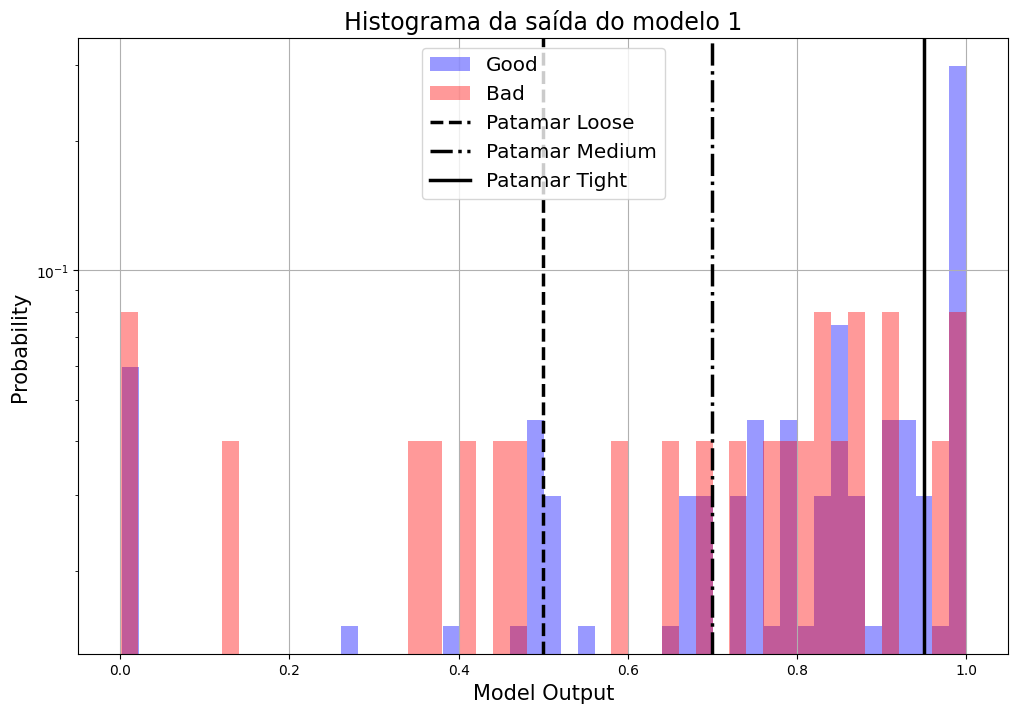

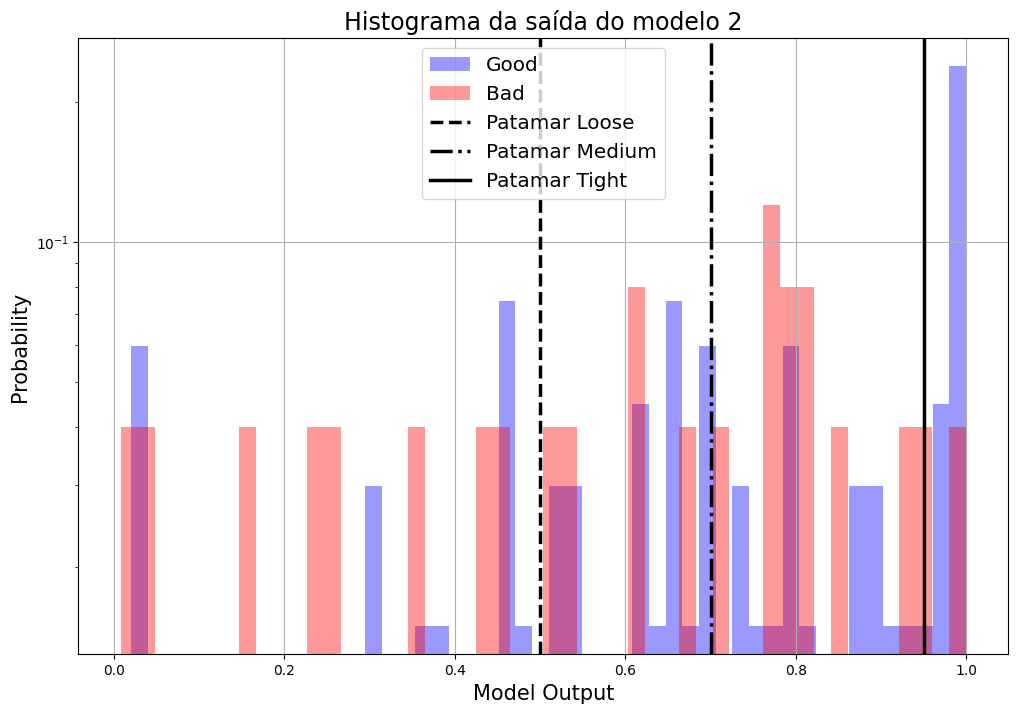

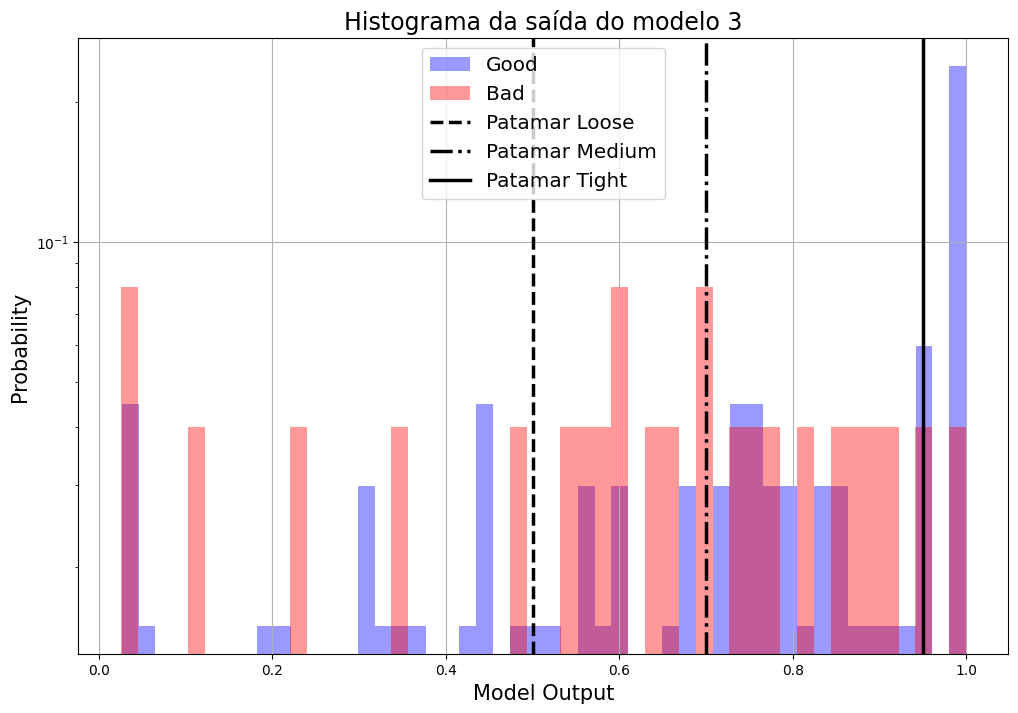

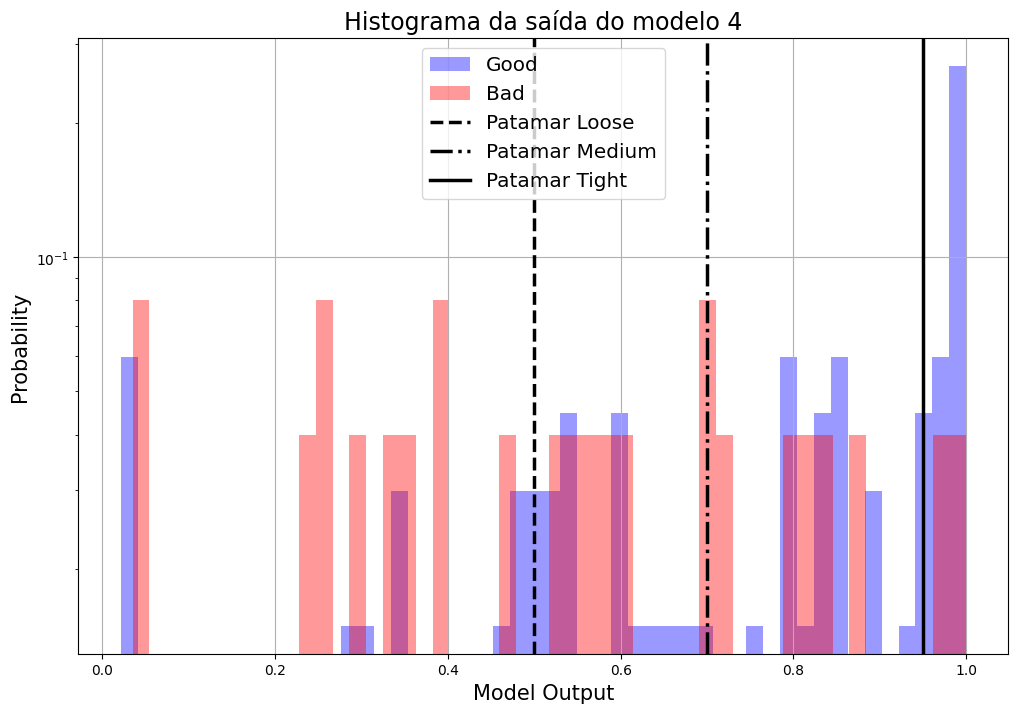

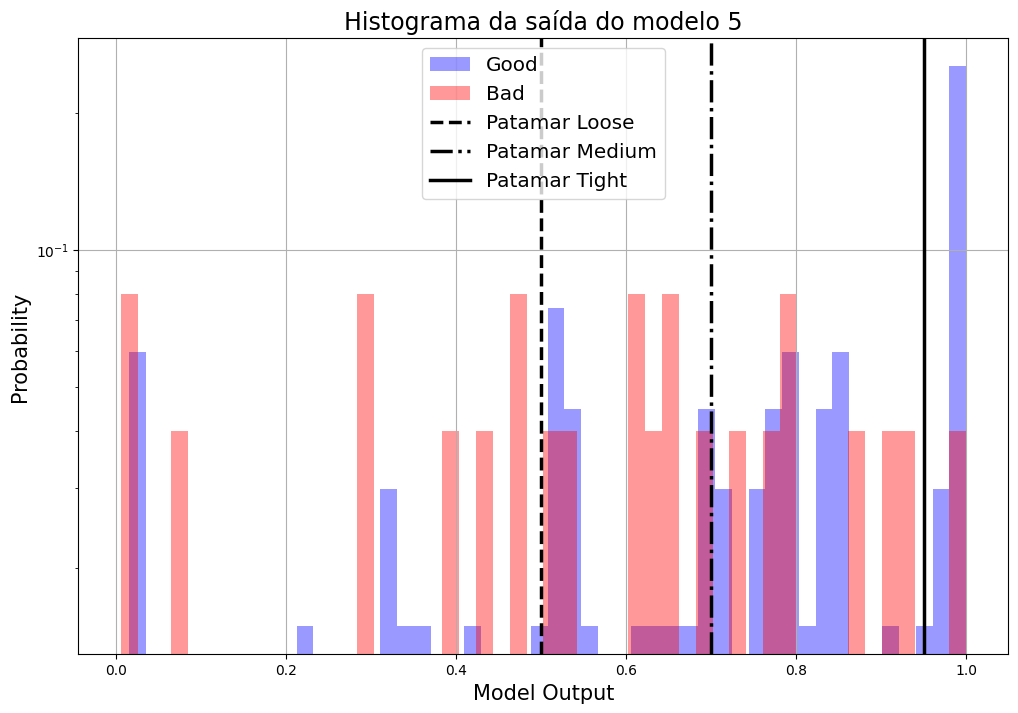

In [20]:
predict_model_cols = X_test.columns

for model_idx in range(5):
    # Separa os valores de teste
    if "probabilidade_model_%i" %(model_idx) not in X_test.columns:
        X_test["probabilidade_model_%i" %(model_idx)] = NB[model_idx].predict_proba(X_test[predict_model_cols])[:,1]

    #Figura
    plt.figure(figsize = (12,8))
    # weights for hist 1
    weights_h1 = (np.ones_like(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)].values)/\
                  len(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)]))
    # weights for hist 2
    weights_h2 = (np.ones_like(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)].values)/\
                  len(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)]))

    plt.hist(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)],
             label='Good', weights=weights_h1,
             color='blue', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
    plt.hist(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)],
             label='Bad', weights=weights_h2,
             color='red', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
    #sns.histplot(x = x_test["probabilidade de pagar"],
    #             hue = y_test)
    plt.ylabel('Probability', fontsize=15)
    plt.xlabel('Model Output', fontsize=15)
    plt.grid()
    plt.title(f"Histograma da saída do modelo {model_idx+1}", fontsize=17)
    plt.axvline(x=.5, color='black', lw=2.5, ls='--', label='Patamar Loose')
    plt.axvline(x=.7, color='black', lw=2.5, ls='-.', label='Patamar Medium')
    plt.axvline(x=.95, color='black', lw=2.5, ls='-', label='Patamar Tight')
    plt.legend(loc='upper center', fontsize='x-large')
    plt.yscale('log')
    plt.show()

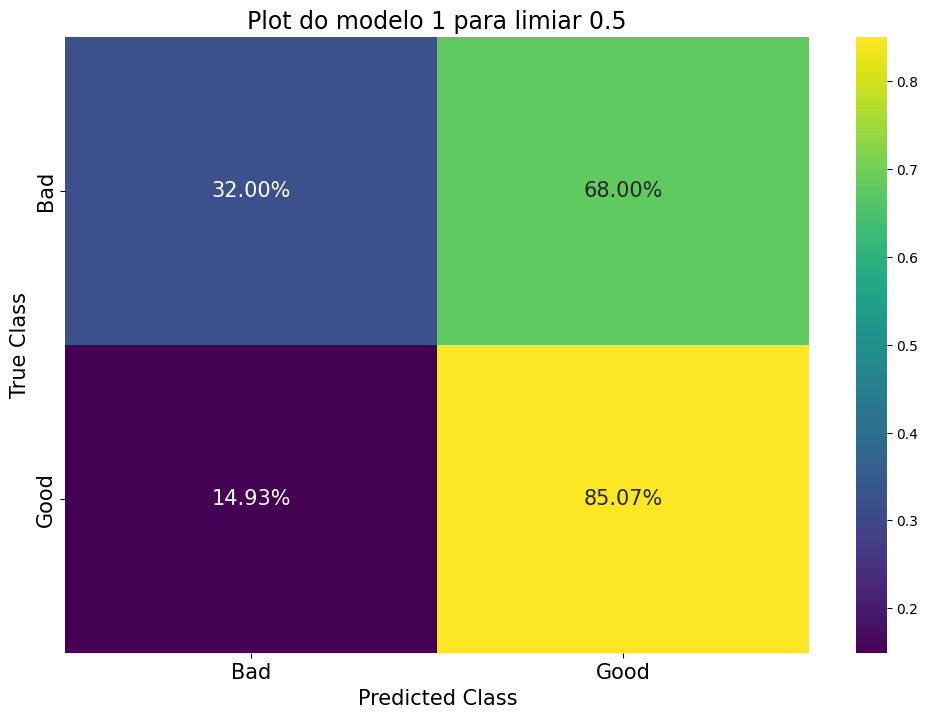

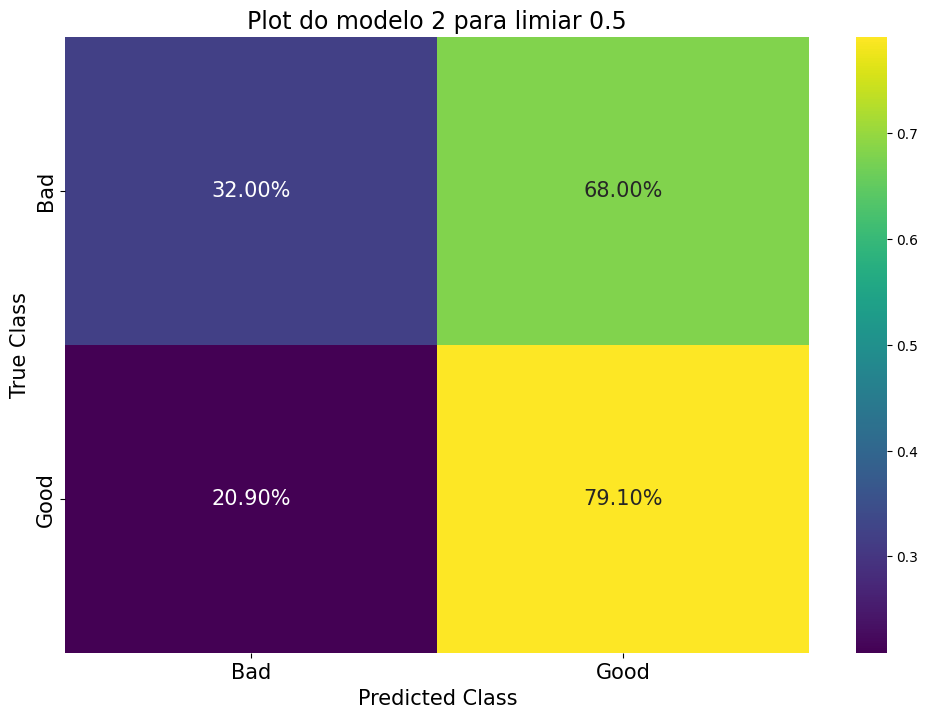

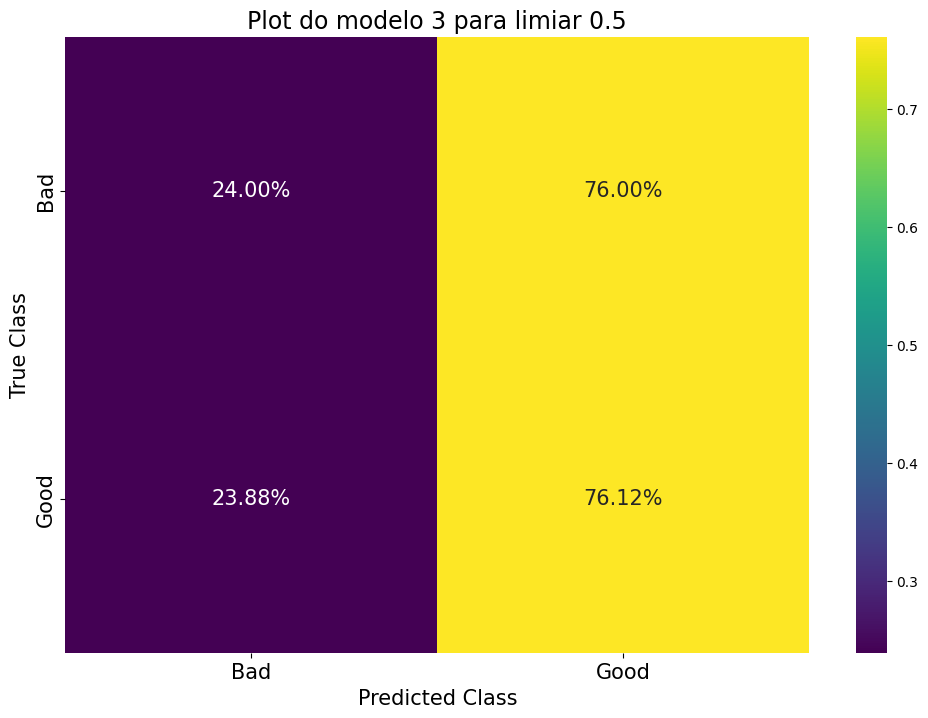

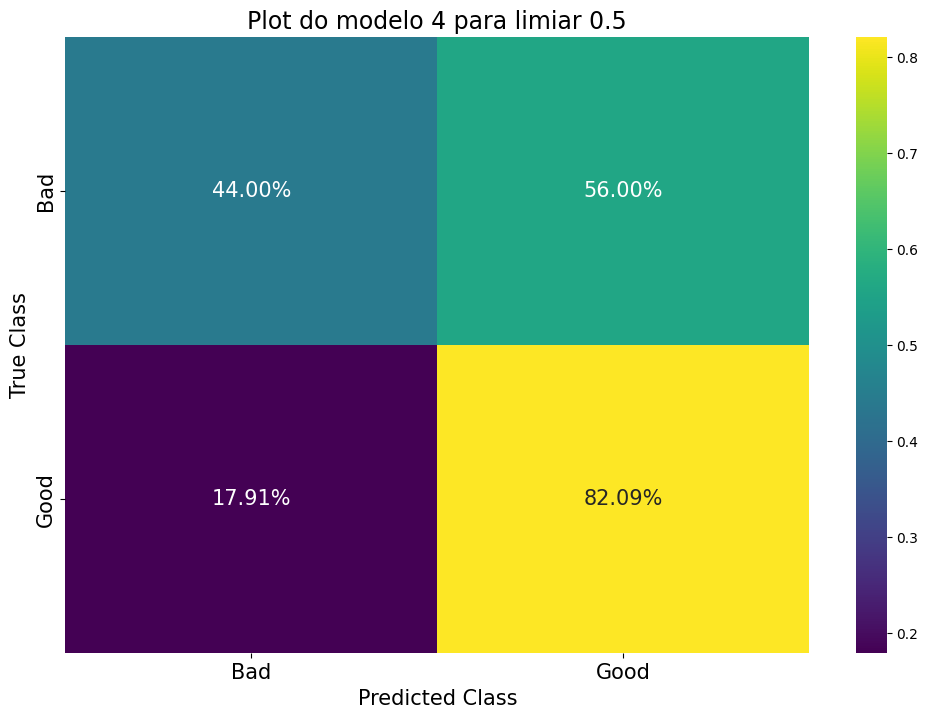

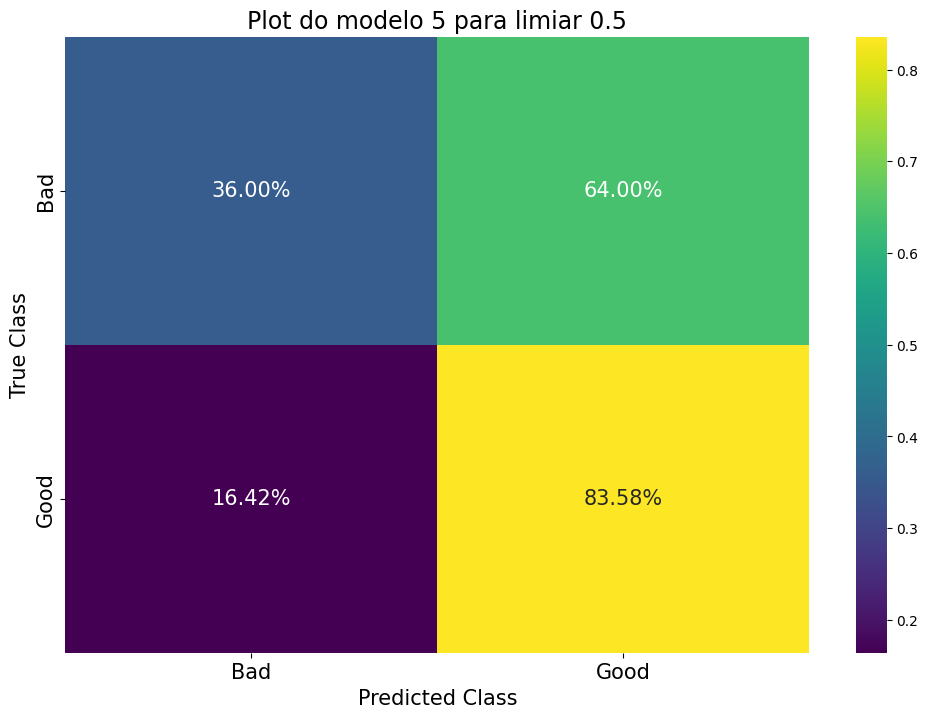

In [21]:
for i in range(5):
    plt.figure(figsize = (12,8))
    matriz = confusion_matrix(y_test, NB[i].predict(X_test[predict_model_cols]), normalize = "true")
    ax = sns.heatmap(matriz, cmap = "viridis", annot = True, annot_kws={"fontsize":15}, fmt=".2%")
    ax.set_title(f"Plot do modelo {i+1} para limiar 0.5", fontsize=17)
    ax.set_ylabel("True Class", fontsize=15)
    ax.set_xlabel("Predicted Class", fontsize=15)
    ax.set_xticklabels(["Bad", "Good"], fontsize=15)
    ax.set_yticklabels(["Bad", "Good"], fontsize=15)
    plt.show()
    "/n"

# LGBM Classifier

In [56]:
# Definindo os parâmetros para o GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'min_child_samples': [5, 10, 20],
    'num_leaves': [5, 10, 20, 31],
    'max_depth': [3, 4, 5, -1],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Configurando o cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=451)

# Configurando o GridSearchCV
grid_search = GridSearchCV(
    estimator=LGBMClassifier(class_weight="balanced", random_state=451),
    param_grid=param_grid,
    scoring="f1_macro",  # Usando f1_macro como métrica principal, pode ajustar conforme necessidade
    cv=skf,
    verbose=2,
    n_jobs=-1  # Utiliza todos os núcleos disponíveis para acelerar a busca
)

# Treinando o GridSearchCV
grid_search.fit(X_train, y_train)

# Exibindo os melhores parâmetros e o melhor score
print("Melhores parâmetros encontrados:", grid_search.best_params_)
print("Melhor score F1_macro encontrado:", grid_search.best_score_)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 199, number of negative: 74
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 273, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [90]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)

#'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 10, 'n_estimators': 100, 'num_leaves': 10

LGBM = cross_validate(estimator=LGBMClassifier(class_weight="balanced",
                                                  n_estimators=15,
                                                  min_child_samples=5,
                                                  num_leaves=5,
                                                  max_depth=4,
                                                  #learning_rate=0.1,
                                                  random_state=451),
                         cv=skf,
                         scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc"],
                         return_estimator=True,
                         return_train_score=True,
                         verbose=2,
                         X=X_train,
                         y=y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 218, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[CV] END .................................................... total time=   0.0s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75
[LightGBM] [In

In [91]:
cv_df = pd.DataFrame(LGBM)
cv_df

,fit_time,score_time,estimator,test_accuracy,train_accuracy,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_roc_auc,train_roc_auc
0,0.016371,0.022164,"LGBMClassifier(class_weight='balanced', max_de...",0.545455,0.692661,0.584918,0.682524,0.604167,0.730679,0.535630,0.671768,0.603333,0.796717
1,0.016980,0.019342,"LGBMClassifier(class_weight='balanced', max_de...",0.563636,0.577982,0.635714,0.659022,0.658333,0.684042,0.560000,0.575085,0.698333,0.795064
2,0.014997,0.016505,"LGBMClassifier(class_weight='balanced', max_de...",0.563636,0.692661,0.527174,0.694781,0.533333,0.746669,0.517544,0.676307,0.566667,0.816757
3,0.014383,0.014028,"LGBMClassifier(class_weight='balanced', max_de...",0.574074,0.684932,0.582418,0.685988,0.602564,0.736229,0.555635,0.667605,0.642735,0.833369
4,0.021396,0.019488,"LGBMClassifier(class_weight='balanced', max_de...",0.462963,0.643836,0.498597,0.671878,0.498214,0.713208,0.447619,0.633371,0.573214,0.800891


In [92]:
teste = ['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro', 'test_roc_auc']
for icol in teste:
    print('%s -> mean: %1.2f +- %1.2f' %(icol, cv_df[icol].mean(), cv_df[icol].std()))

test_accuracy -> mean: 0.54 +- 0.05
test_precision_macro -> mean: 0.57 +- 0.05
test_recall_macro -> mean: 0.58 +- 0.06
test_f1_macro -> mean: 0.52 +- 0.05
test_roc_auc -> mean: 0.62 +- 0.05


Média de acurácia de treino dos modelos: 0.6584139751162498 
 Desvio padrão de acurácia de treino dos modelos: 0.04411512796890098
Média de acurácia de teste dos modelos: 0.5419528619528619 
 Desvio padrão de acurácia de teste dos modelos: 0.04055560796840099


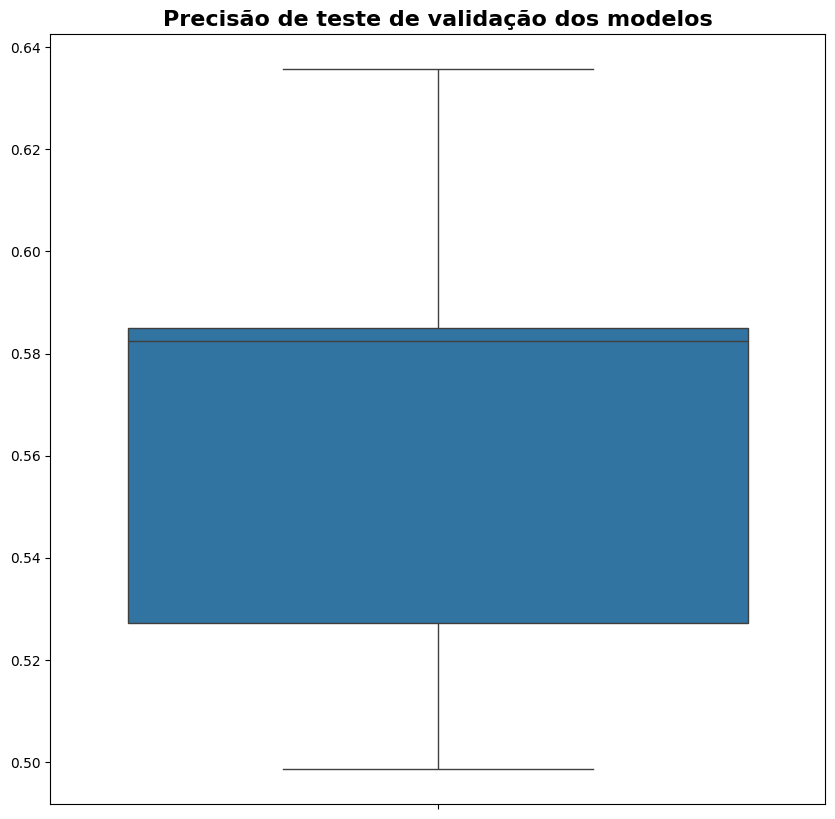

In [93]:
print("Média de acurácia de treino dos modelos:", LGBM["train_accuracy"].mean(), "\n", "Desvio padrão de acurácia de treino dos modelos:", LGBM["train_accuracy"].std())
print("Média de acurácia de teste dos modelos:", LGBM["test_accuracy"].mean(), "\n", "Desvio padrão de acurácia de teste dos modelos:", LGBM["test_accuracy"].std())

plt.figure(figsize = (10,10))
sns.boxplot(LGBM["test_precision_macro"])
plt.title("Precisão de teste de validação dos modelos", fontsize = 16, weight = "bold");


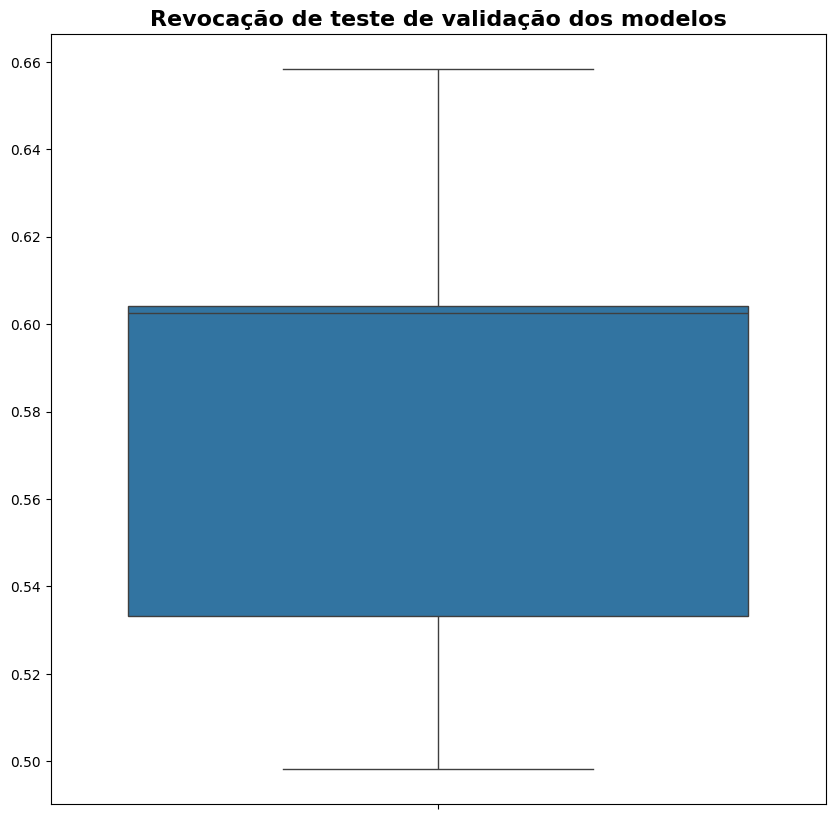

In [94]:
plt.figure(figsize = (10,10))
sns.boxplot(LGBM["test_recall_macro"])
plt.title("Revocação de teste de validação dos modelos", fontsize = 16, weight = "bold");

In [95]:
LGBM = LGBM["estimator"]
LGBM

[LGBMClassifier(class_weight='balanced', max_depth=4, min_child_samples=5,
                n_estimators=15, num_leaves=5, random_state=451),
 LGBMClassifier(class_weight='balanced', max_depth=4, min_child_samples=5,
                n_estimators=15, num_leaves=5, random_state=451),
 LGBMClassifier(class_weight='balanced', max_depth=4, min_child_samples=5,
                n_estimators=15, num_leaves=5, random_state=451),
 LGBMClassifier(class_weight='balanced', max_depth=4, min_child_samples=5,
                n_estimators=15, num_leaves=5, random_state=451),
 LGBMClassifier(class_weight='balanced', max_depth=4, min_child_samples=5,
                n_estimators=15, num_leaves=5, random_state=451)]

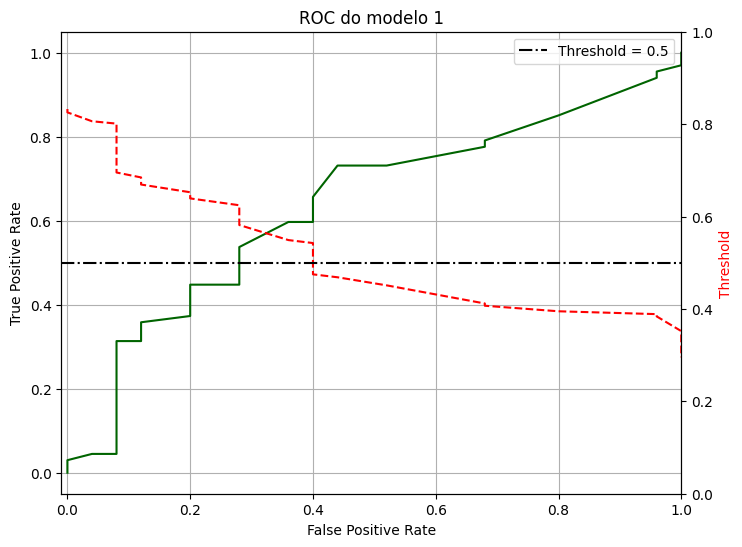

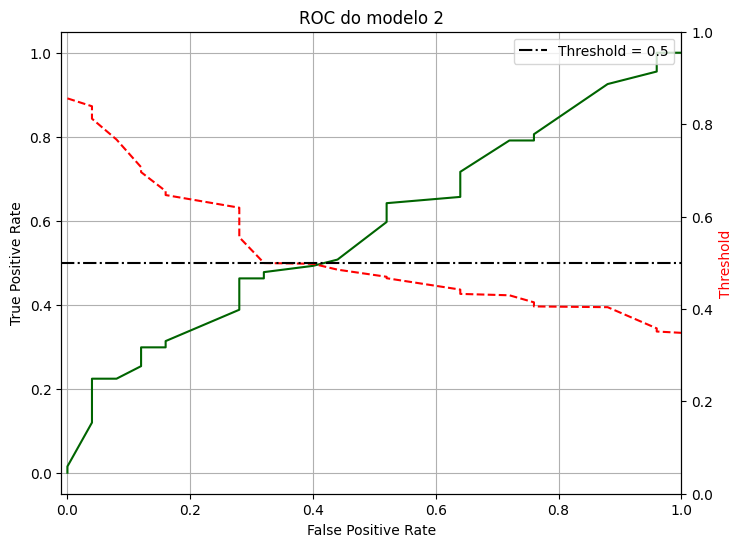

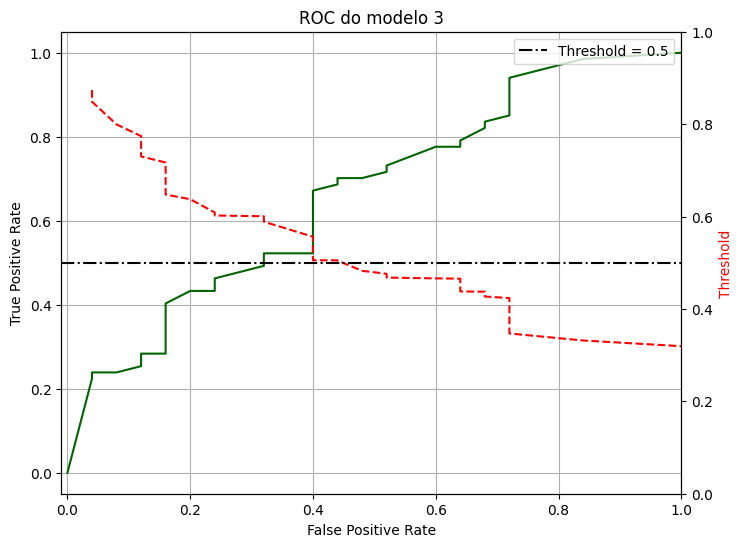

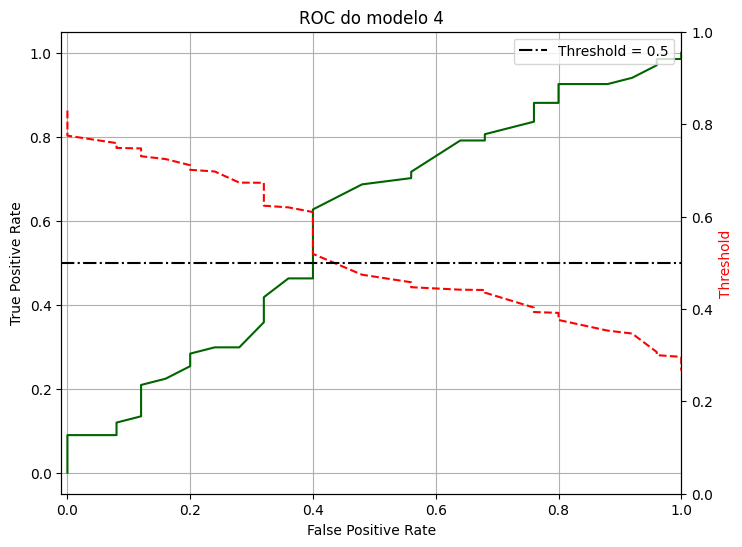

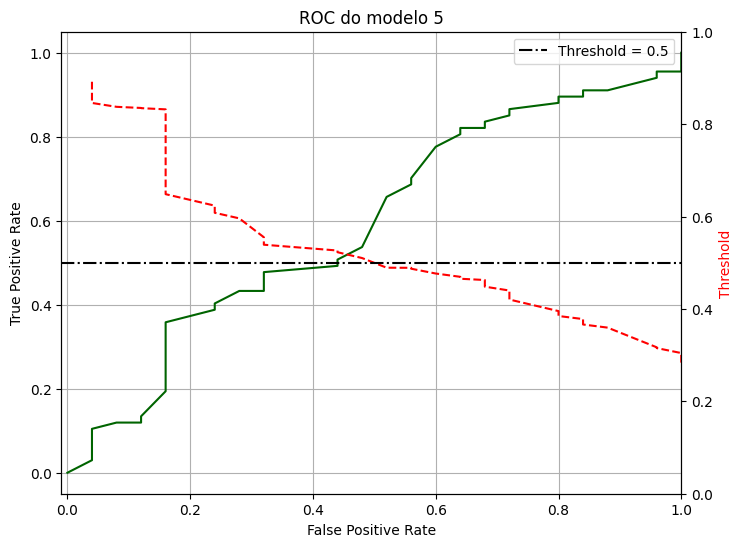

In [96]:
X_test = X_test[X_train.columns]
for i in range(5):
    y_pred_proba = LGBM[i].predict_proba(X_test)[::,1]
    fpr, tpr, sarrafo = roc_curve(y_test,  y_pred_proba)
    sarrafo = sarrafo[fpr <= 1]

    #create ROC curve
    plt.figure(figsize = (8,6))
    plt.plot(fpr,tpr, lw = 1.5, color = "darkgreen")
    plt.grid()
    plt.title(f"ROC do modelo {i + 1}")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, sarrafo, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([0,1])
    ax2.set_xlim([-0.01,1])
    ax2.axhline(y = 0.5, lw = 1.5, color = "black", ls = "-.", label = "Threshold = 0.5")
    plt.legend()

    plt.show()

In [97]:
for i in range(5):
    scores = [accuracy_score(y_test, LGBM[i].predict(X_test)),
                             balanced_accuracy_score(y_test, LGBM[i].predict(X_test)),
                             f1_score(y_test, LGBM[i].predict(X_test), average = "macro"),
                             precision_score(y_test, LGBM[i].predict(X_test)),
                             roc_auc_score(y_test, LGBM[i].predict(X_test))]
    scores_names = ["Acurácia", "Acurácia_balanceada", "F1_macro", "Precisão", "ROC"]

    print("Modelo", i + 1)
    print(pd.DataFrame([scores], columns = scores_names))

Modelo 1
   Acurácia  Acurácia_balanceada  F1_macro  Precisão      ROC
0  0.608696              0.60597   0.57473  0.803922  0.60597
Modelo 2
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.532609             0.591343  0.523086  0.815789  0.591343
Modelo 3
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.663043             0.630746  0.613288  0.810345  0.630746
Modelo 4
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.619565             0.613433   0.58371  0.807692  0.613433
Modelo 5
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.532609             0.528657  0.501449      0.75  0.528657


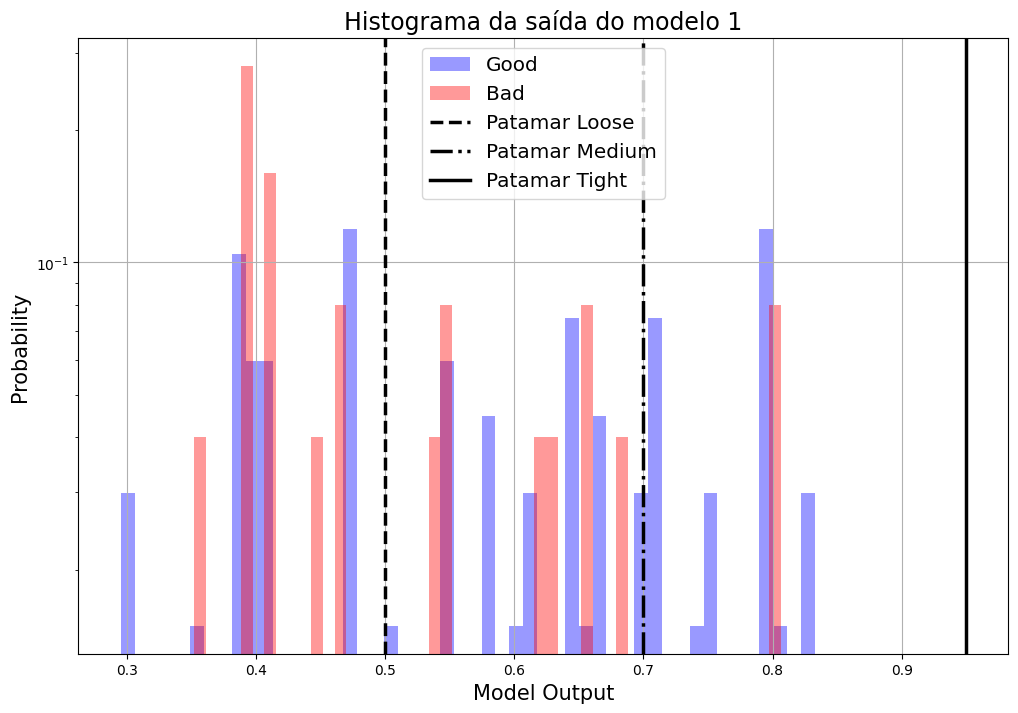

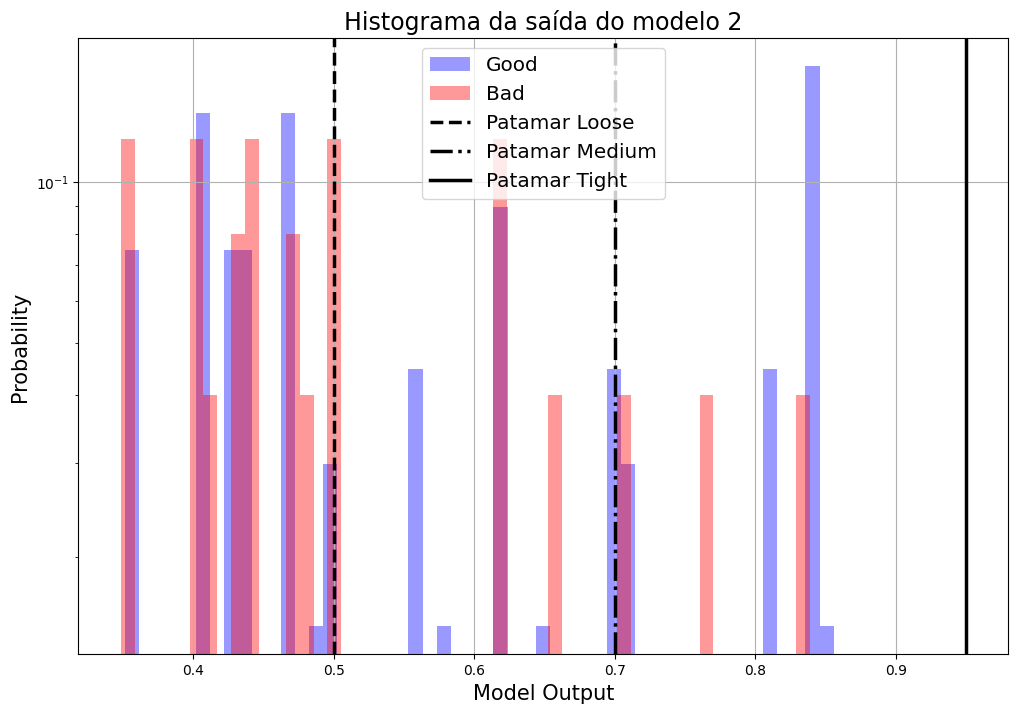

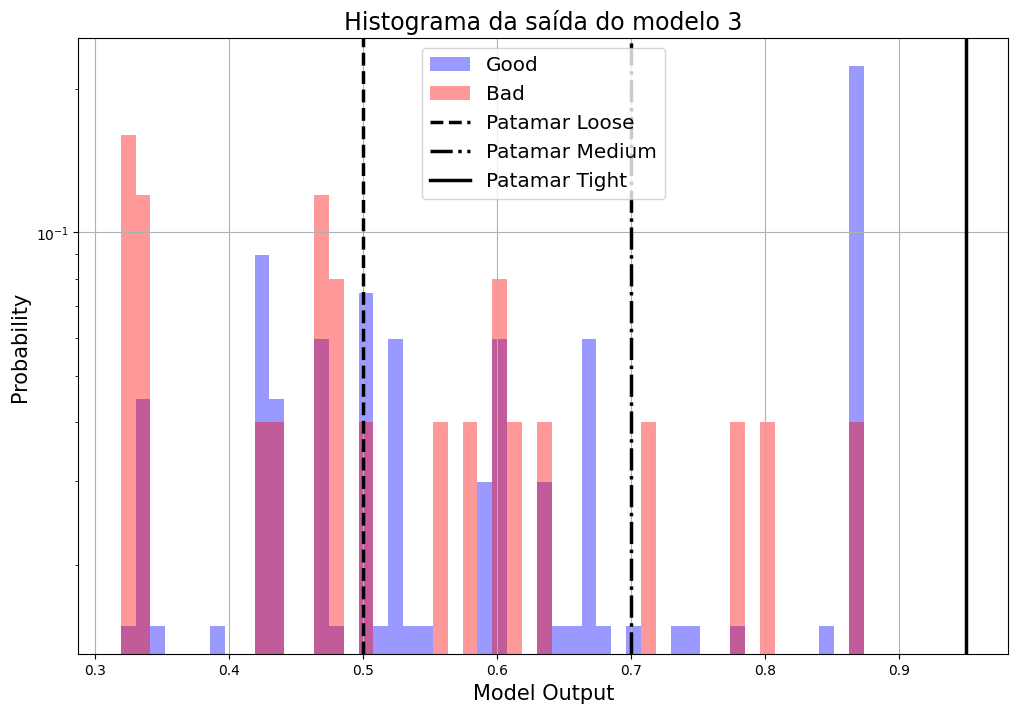

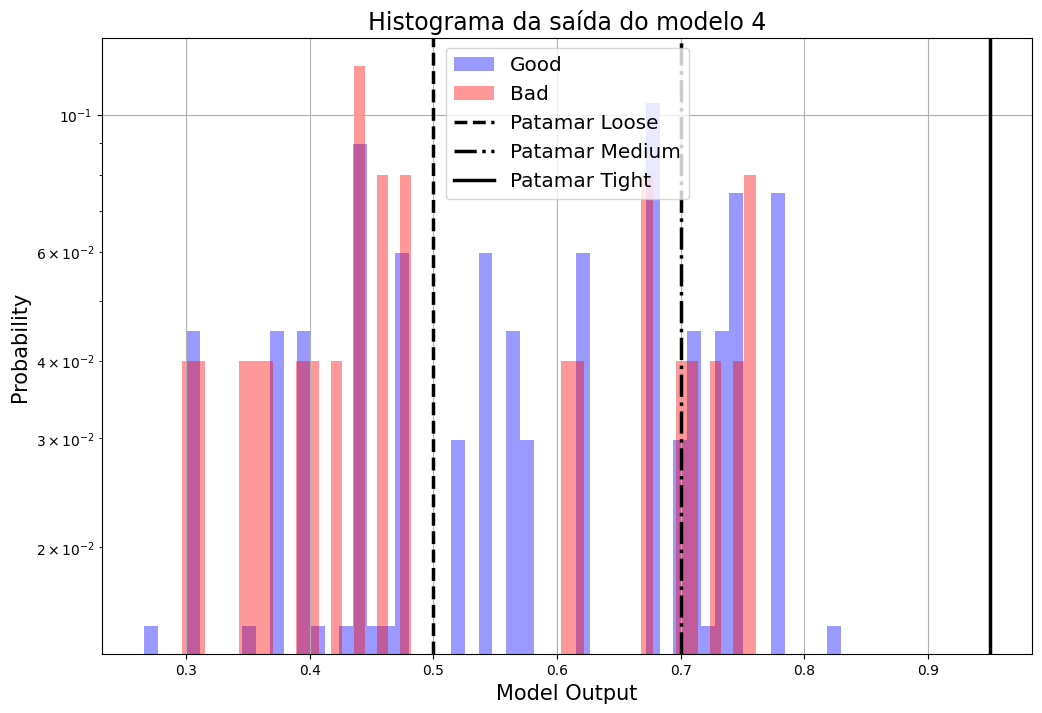

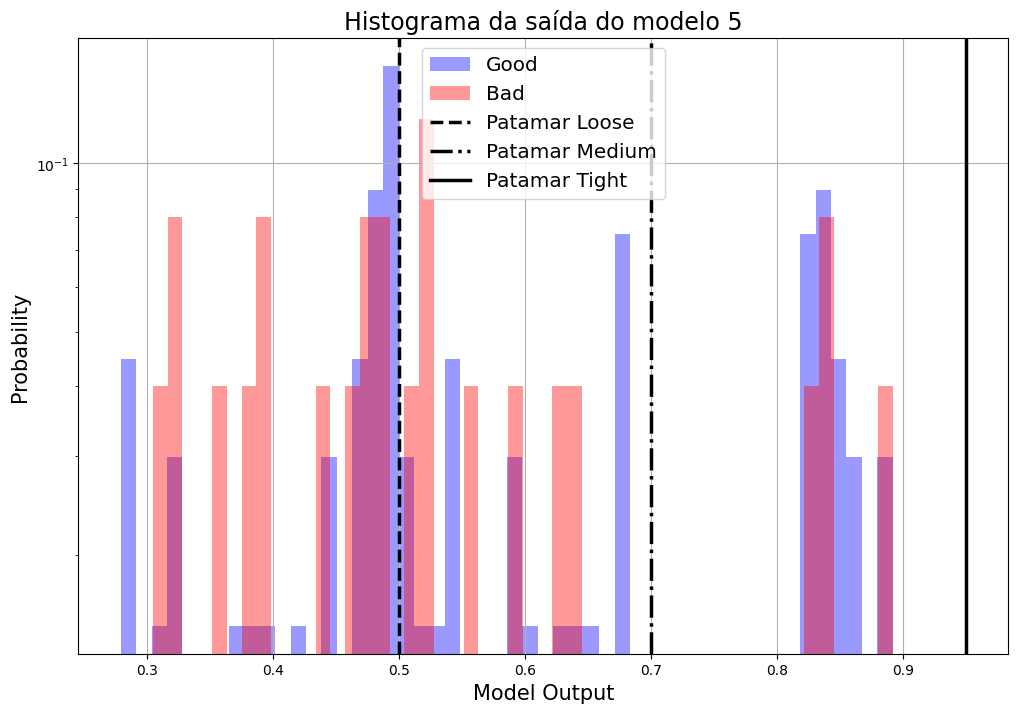

In [98]:
predict_model_cols = X_test.columns

for model_idx in range(5):
    # Separa os valores de teste
    if "probabilidade_model_%i" %(model_idx) not in X_test.columns:
        X_test["probabilidade_model_%i" %(model_idx)] = LGBM[model_idx].predict_proba(X_test[predict_model_cols])[:,1]

    #Figura
    plt.figure(figsize = (12,8))
    # weights for hist 1
    weights_h1 = (np.ones_like(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)].values)/\
                  len(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)]))
    # weights for hist 2
    weights_h2 = (np.ones_like(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)].values)/\
                  len(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)]))

    plt.hist(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)],
             label='Good', weights=weights_h1,
             color='blue', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
    plt.hist(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)],
             label='Bad', weights=weights_h2,
             color='red', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
    #sns.histplot(x = x_test["probabilidade de pagar"],
    #             hue = y_test)
    plt.ylabel('Probability', fontsize=15)
    plt.xlabel('Model Output', fontsize=15)
    plt.grid()
    plt.title(f"Histograma da saída do modelo {model_idx+1}", fontsize=17)
    plt.axvline(x=.5, color='black', lw=2.5, ls='--', label='Patamar Loose')
    plt.axvline(x=.7, color='black', lw=2.5, ls='-.', label='Patamar Medium')
    plt.axvline(x=.95, color='black', lw=2.5, ls='-', label='Patamar Tight')
    plt.legend(loc='upper center', fontsize='x-large')
    plt.yscale('log')
    plt.show()

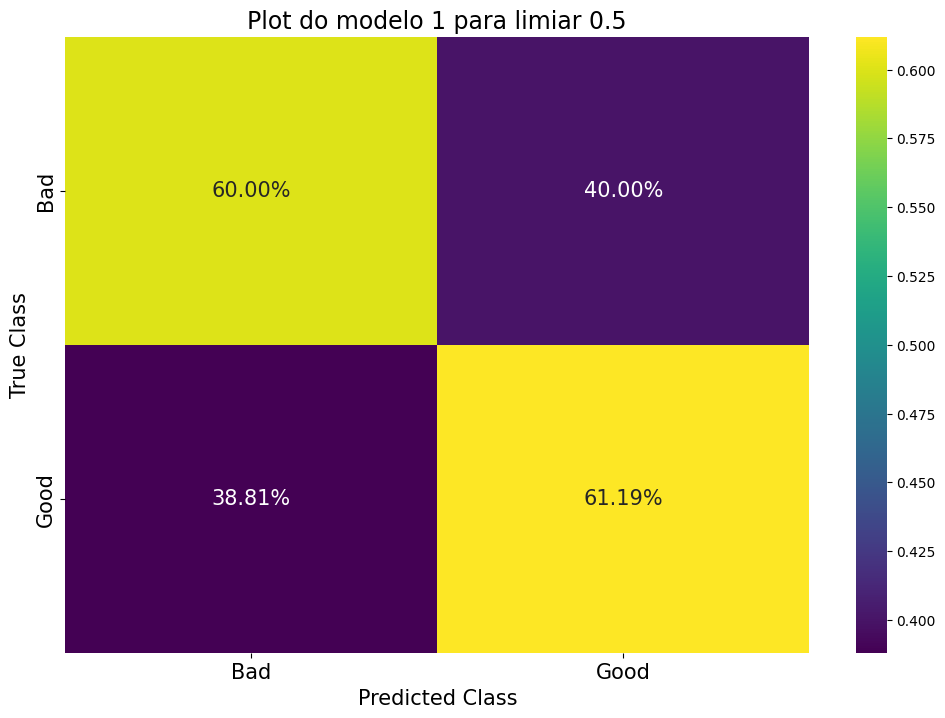

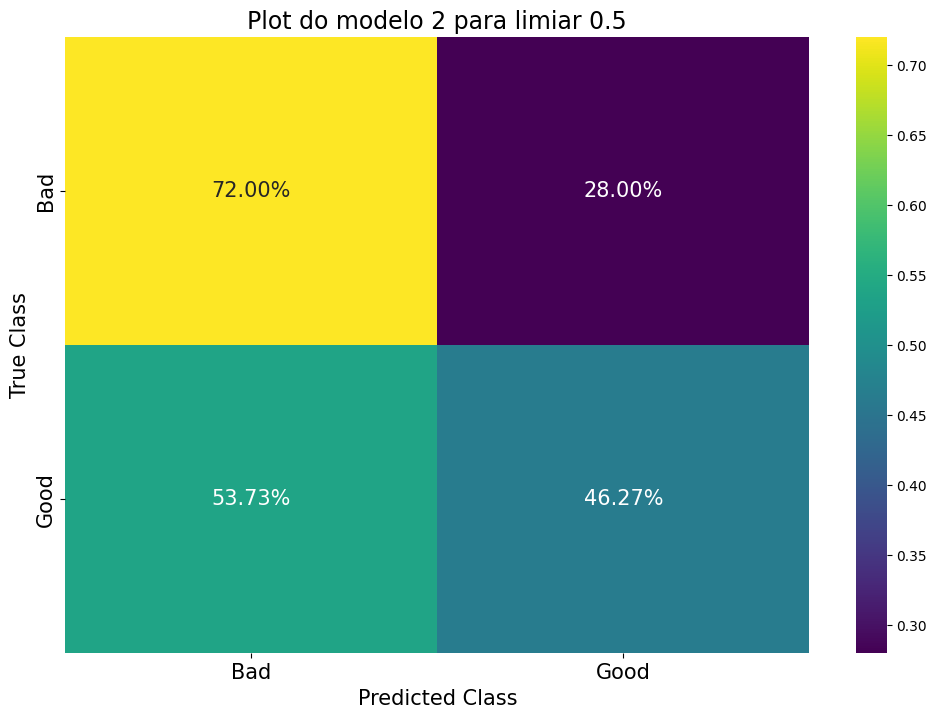

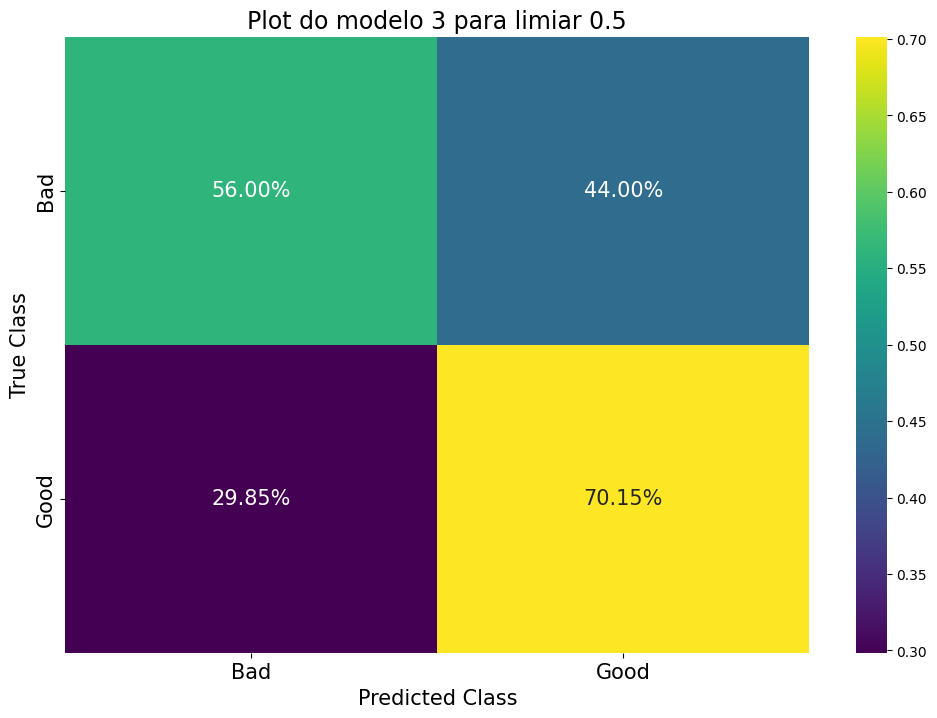

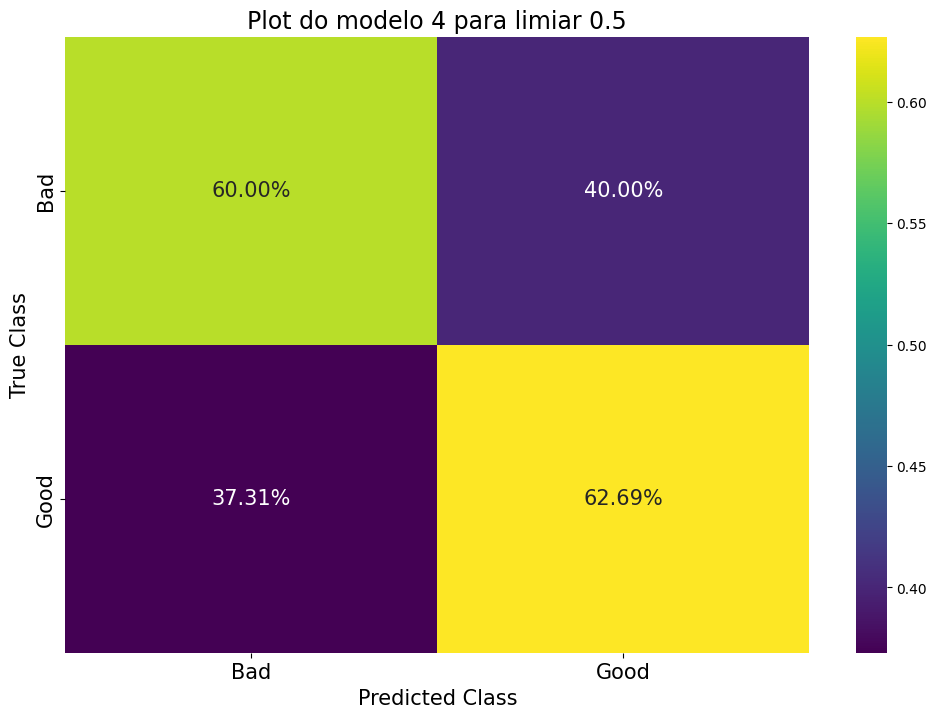

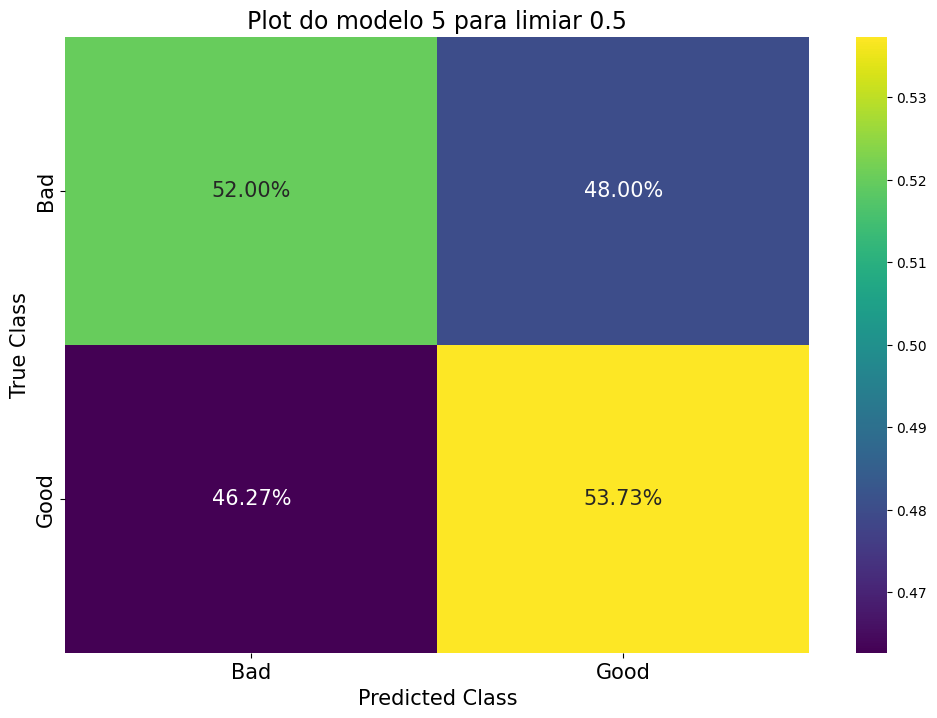

In [99]:
for i in range(5):
    plt.figure(figsize = (12,8))
    matriz = confusion_matrix(y_test, LGBM[i].predict(X_test[predict_model_cols]), normalize = "true")
    ax = sns.heatmap(matriz, cmap = "viridis", annot = True, annot_kws={"fontsize":15}, fmt=".2%")
    ax.set_title(f"Plot do modelo {i+1} para limiar 0.5", fontsize=17)
    ax.set_ylabel("True Class", fontsize=15)
    ax.set_xlabel("Predicted Class", fontsize=15)
    ax.set_xticklabels(["Bad", "Good"], fontsize=15)
    ax.set_yticklabels(["Bad", "Good"], fontsize=15)
    plt.show()
    "/n"

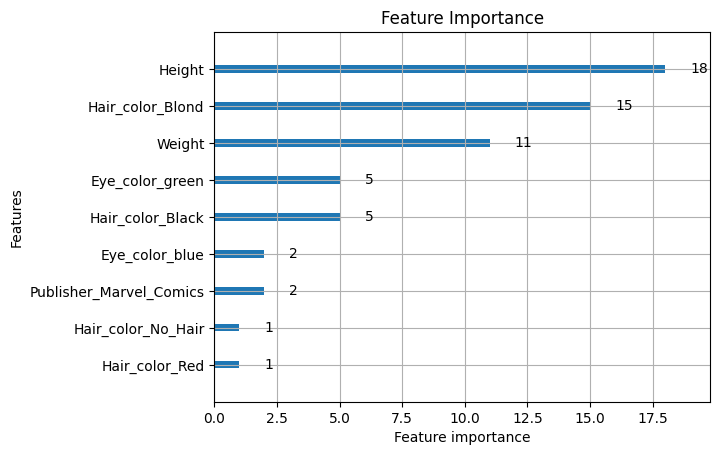

In [100]:
import lightgbm as lgb
lgb.plot_importance(LGBM[2], max_num_features=20)  # max_num_features define o número de features exibidas
plt.title("Feature Importance")
plt.show()